# **TPF Data Science Notebooks**
# *Introductory z/TPF data analysis with Jupyter Notebook*
---
### This Jupyter notebook demonstrates how to read continuous data collection (CDC) and name-value pair collection data that is generated from a z/TPF system and use data analysis techniques to produce different statistical and visual outputs for gathering operational insights.

## Data Collection
---
This Jupyter notebook is a walkthrough for analyzing data from [CDC](https://www.ibm.com/support/knowledgecenter/en/SSB23S_1.1.0.15/gtps3/cdcdetails.html) and [name-value pair collection](https://www.ibm.com/support/knowledgecenter/en/SSB23S_1.1.0.15/gtps3/cnvpcp.html) to investigate a fictitious problem on our z/TPF system. The sample CDC and name-value pair collection data were collected from a z/TPF system where specialized application drivers were consuming specific system resource over time. The application drivers ran profiles to dynamically set name-value pairs and emulate the expected usage of system resources for certain events. For this notebook, the sample data show our z/TPF system experiencing different periodic increases of CPU utilization. **To minimize the size of the data sets for this investigation, the data collections were triggered at 10-second intervals where 60 seconds represents 24 hours.**

The CDC and name-value pair collection data were transformed into comma-separated values (CSV) files to more conveniently import the data sets into the Python environment. The CDC data was collected in the [z/TPF collection support file system](https://www.ibm.com/support/knowledgecenter/en/SSB23S_1.1.0.15/gtps3/cdcfs.html), with minor modifications to the data structures to include timestamps, and parsed into CSV files using the [z/TPF DFDL API support](https://www.ibm.com/support/knowledgecenter/en/SSB23S_1.1.0.15/gtps6/ztpfdfdlsapiupport.html). The name-value pair collection data was routed through the [runtime metrics collection (RTMC)](https://www.ibm.com/support/knowledgecenter/en/SSB23S_1.1.0.15/gtps3/s3crtmc.html) process, pivoted into a more accessible tabular format for the relevant fields, and exported into CSV files by using a database management system.

Several open-source Python libraries for data science are used in this project, all of which are bundled in the [Anaconda Python distribution](https://www.anaconda.com/distribution/). While there are numerous other libraries with overlapping purposes, the following libraries are some of the most commonly used by Python data scientists:
* **numpy** is a scientific computing library that supports multi-dimensional arrays.
* **matplotlib** is a low-level graphical plotting library (requires numpy).
* **pandas** is a high-performance data manipulation & analysis library (requires matplotlib and numpy).
* **seaborn** is a high-level data visualization library for pandas DataFrames (requires pandas and matplotlib).

It is standard practice to import major libraries at the start of a notebook to check for any dependency issues.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

# Use Seaborn's aesthetic style for Matplotlib figures
sns.set()

# Register Pandas Formatters and Converters with matplotlib
pd.plotting.register_matplotlib_converters()

The sample data is retrieved from the project's GitHub repository and stored into DataFrames, two-dimensional labeled arrays in pandas, by using the read_csv() function. The first column, *TIMESTAMP*, exists in both the CDC and name-value pair collection data to identify the starting time of each collection period. We want to convert the column from the "stringify" ISO-8601 datetime format to a valid Timestamp data type and collapse it as the DataFrame index for our analysis. 

In [2]:
# Retrieve sample CDC and NVPC data from GitHub
cdc_syslst_df = pd.read_csv('https://raw.githubusercontent.com/IBM/tpf-ds-notebooks/master/data/cdc_syslst.csv', index_col=0, parse_dates=True)
cdc_sysmsg_df = pd.read_csv('https://raw.githubusercontent.com/IBM/tpf-ds-notebooks/master/data/cdc_sysmsg.csv', index_col=0, parse_dates=True)
cdc_tcpip_df = pd.read_csv('https://raw.githubusercontent.com/IBM/tpf-ds-notebooks/master/data/cdc_tcpip.csv', index_col=0, parse_dates=True)
nvpc_df = pd.read_csv('https://raw.githubusercontent.com/IBM/tpf-ds-notebooks/master/data/nvpc_data.csv', index_col=0, parse_dates=True)

**Note:** *If the Jupyter Notebook environment does not have connectivity to GitHub, there are several other ways to read the sample data into this notebook. The URLs can be changed to use IBM Cloud Object Storage, another cloud storage solution, or any accessible remote system that can host the sample data. The sample data also can be uploaded to the file system that is shared by the Jupyter Notebook environment, on [JupyterLab](https://jupyterlab.readthedocs.io) which you can do from the Files tab, and read by invoking the same read_csv() function with the appropriate file path instead:*
```python
cdc_syslst_df = pd.read_csv('data/cdc_syslst.csv', index_col=0, parse_dates=True)
cdc_sysmsg_df = pd.read_csv('data/cdc_sysmsg.csv', index_col=0, parse_dates=True)
cdc_tcpip_df = pd.read_csv('data/cdc_tcpip.csv', index_col=0, parse_dates=True)
nvpc_data_df = pd.read_csv('data/nvpc_data.csv', index_col=0, parse_dates=True)
```

## Problem Selection
---

The first major step of any data analysis effort is defining the problem that you are trying to solve. We have been told that "unexpected CPU utilization growths" were being experienced on the z/TPF system. The specific data set that contains the CPU utilization metrics, which you can see in the *PRCSSR_UTL* column in the *cdc_sysmsg_df* DataFrame, needs to be examined to better understand the problem before we can develop an hypothesis. 

In [3]:
# Show CDC system message data columns
cdc_sysmsg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210 entries, 2019-02-28 13:51:10 to 2019-02-28 14:26:00
Data columns (total 19 columns):
SYSM_TIME_DIFF_MS     210 non-null int64
HIGH_SPD_MSGS         210 non-null int64
LOW_SPD_MSGS          210 non-null int64
ROUTED_ENTRIES        210 non-null int64
CRTD_ENTS             210 non-null int64
SSCP_INPUT_MSGS       210 non-null int64
PRCSSR_UTL            210 non-null int64
NUMBER_OF_ISTREAMS    210 non-null int64
USABLE_ISTREAMS       210 non-null int64
CDC_INSDB_IN_MSGS     210 non-null int64
COMMITS               210 non-null int64
CF_REQUESTS           210 non-null int64
SHUTDOWN1             210 non-null int64
SHUTDOWN2             210 non-null int64
TRACES                210 non-null int64
GP_UTIL               210 non-null int64
GP_CAP                210 non-null int64
GP_ENGINES            210 non-null int64
IS_CAP                210 non-null int64
dtypes: int64(19)
memory usage: 32.8 KB


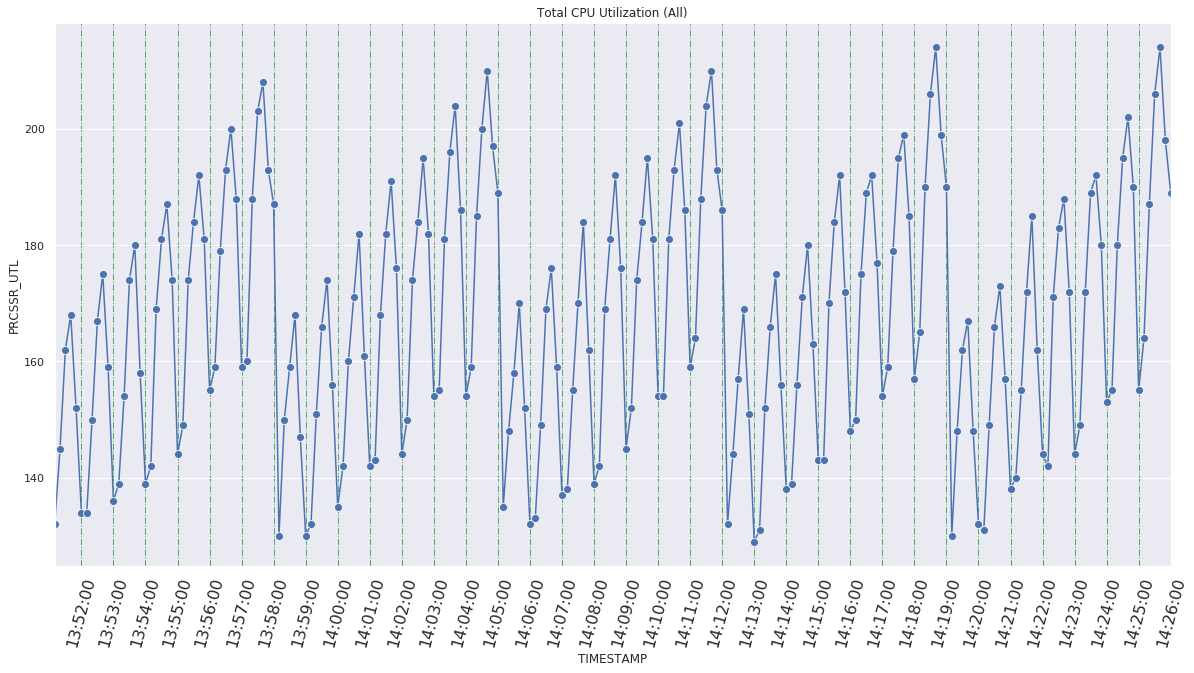

In [4]:
# Define variables for collection date ranges
first_collection_datetime = cdc_sysmsg_df.first_valid_index()
last_collection_datetime = cdc_sysmsg_df.last_valid_index()

# Construct line graph of CPU utilization
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=cdc_sysmsg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_df, marker='o', markersize=8)
ax.set_title('Total CPU Utilization (All)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

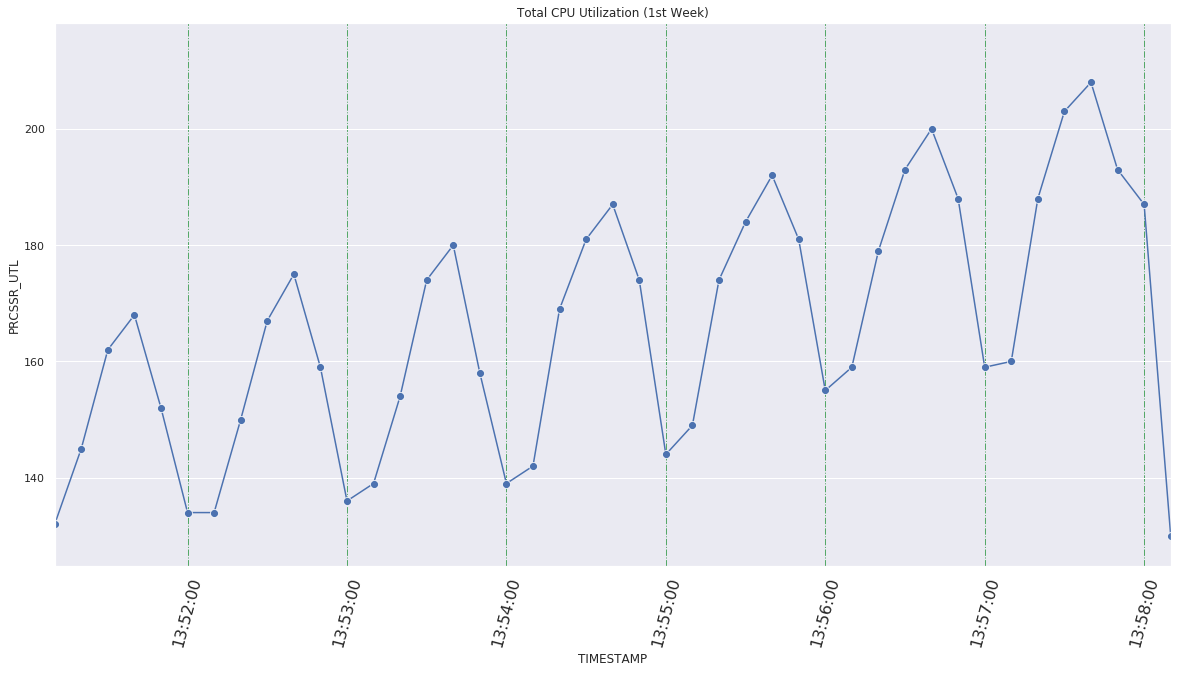

In [5]:
# Define starting and ending times for a single week (60 seconds = 1 day)
first_collection_week1_datetime = first_collection_datetime
last_collection_week1_datetime = first_collection_week1_datetime + pd.Timedelta(seconds=60*7)

# Construct line graph of CPU utilization for a single week
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=cdc_sysmsg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_df, marker='o', markersize=8)
ax.set_title('Total CPU Utilization (1st Week)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_week1_datetime, last_collection_week1_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

The previous line graphs show that the CPU utilization has the expected traffic pattern of daily peak hours (*60 seconds = fictitious 24 hours*) but also slowly builds up over the course of seven days and then drops to the original level. Advanced time series analysis techniques can be performed to statistically prove that both the daily and weekly seasonality trends exist in our data sets. For the sake of simplicity, we will assume that these trend patterns have been confirmed by our enterprise environment experts outside of this notebook. We will focus on a simple time series analysis technique to smooth out the daily trend pattern by calculating the rolling average of the CPU utilization.

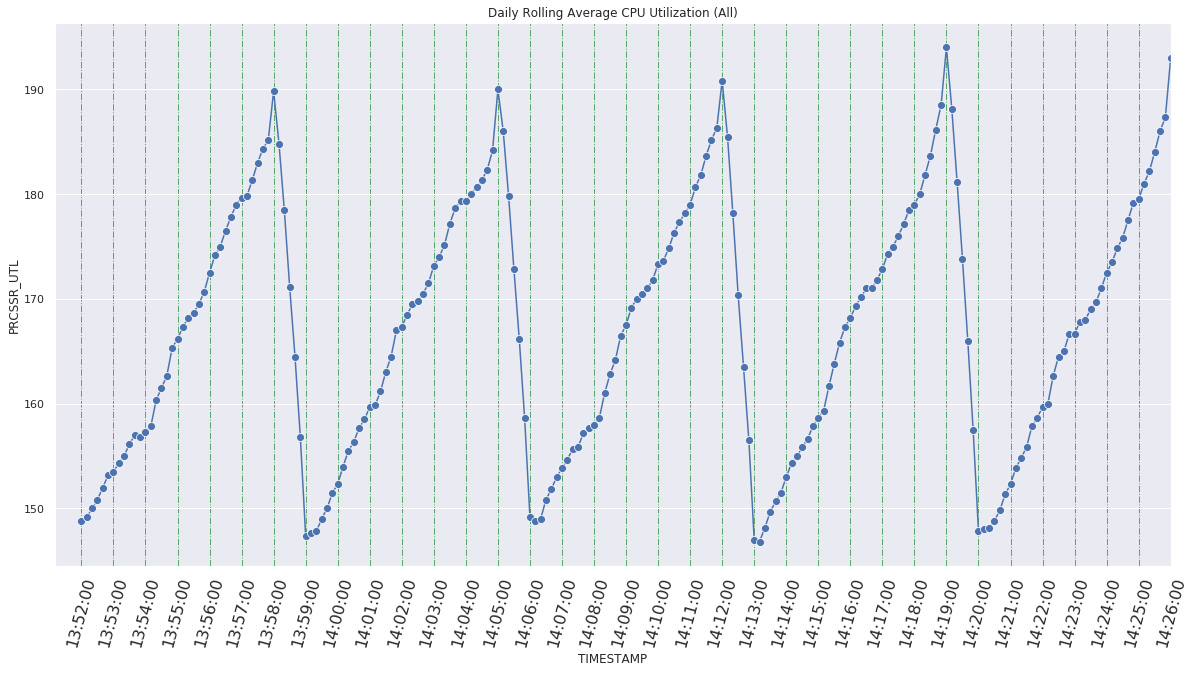

In [6]:
# Calculate daily rolling average of CPU utilization (six collections per day)
cdc_sysmsg_dailyavg_df = cdc_sysmsg_df.rolling(6).mean()

# Construct line graph of daily rolling average CPU utilization
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=8)
ax.set_title('Daily Rolling Average CPU Utilization (All)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

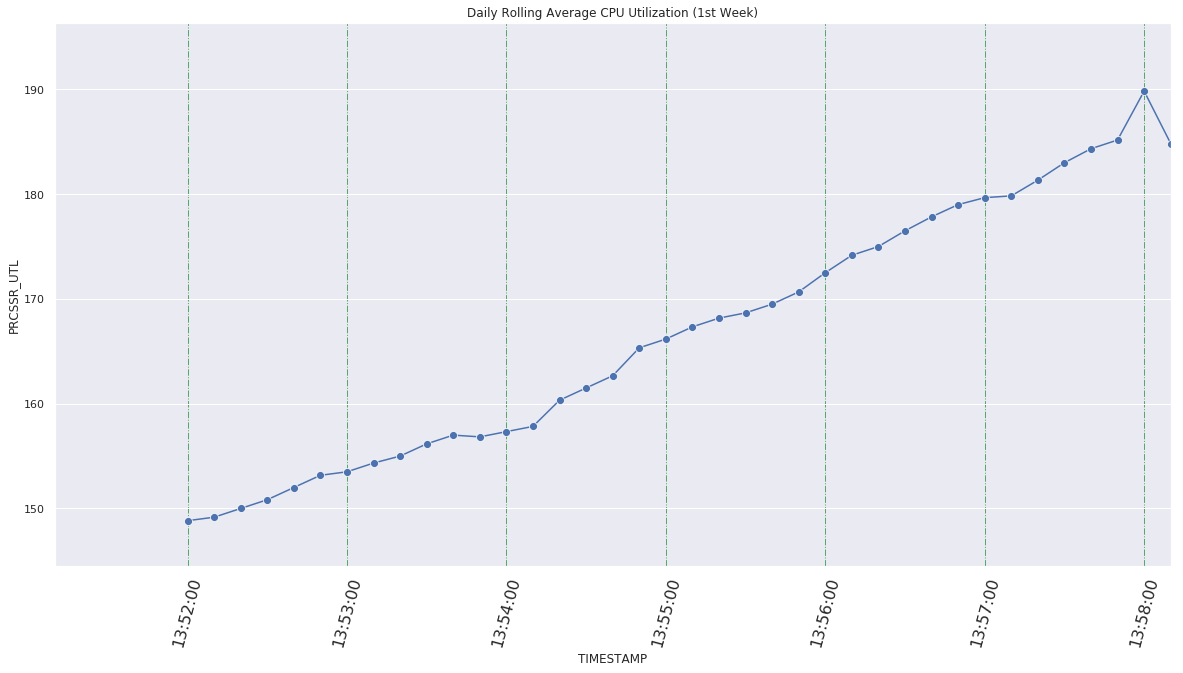

In [7]:
# Construct line graph of daily rolling average CPU utilization for a single week
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=8)
ax.set_title('Daily Rolling Average CPU Utilization (1st Week)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_week1_datetime, last_collection_week1_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

We want to investigate possible causes of this undesirable buildup in CPU utilization in our z/TPF system. Plotting the daily rolling averages is a better way to highlight the weekly trend pattern in our collected data set. This statistical method is even more useful later when they are applied and correlated on multiple metrics.

## Data Exploration
---

A data scientist can spend a significant amount of time evaluating the data for importance before modeling the problem. The goal for solving the specific problem set is to manipulate and filter the data to only the relevant columns in the DataFrame. This iterative process requires repeatedly performing statistical and visual analysis to better understand the collected data. For this project, we want to refine our data sets for investigating unusual CPU utilization.

We have identified the *PRCSSR_UTL* column in the *cdc_sysmsg_df* DataFrame as the target variable that shows the problem that we were experiencing. The next step in investigating the cause of the weekly CPU utilization trends is to evaluate the other data sets and determine their usefulness. The CDC TCP/IP data set is a great starting point because we can potentially eliminate an entire DataFrame from further analysis if the problem is not specific to an Internet server application.

In [8]:
# Show CDC TCP/IP data columns
display(cdc_tcpip_df.info())

# Display statistical summary of CDC TCP/IP data
display(cdc_tcpip_df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1050 entries, 2019-02-28 13:51:10 to 2019-02-28 14:26:00
Data columns (total 9 columns):
TCPIP_APP_NAME         1050 non-null object
TCPIP_PORT             1050 non-null int64
TCPIP_WEIGHT           1050 non-null int64
TCPIP_PACKTS_SENT      1050 non-null int64
TCPIP_PACKETS_RECVD    1050 non-null int64
TCPIP_BYTES_SENT       1050 non-null int64
TCPIP_BYTES_RECVD      1050 non-null int64
TCPIP_MSG_SENT         1050 non-null int64
TCPIP_MSG_RECVD        1050 non-null int64
dtypes: int64(8), object(1)
memory usage: 82.0+ KB


None

,TCPIP_PORT,TCPIP_WEIGHT,TCPIP_PACKTS_SENT,TCPIP_PACKETS_RECVD,TCPIP_BYTES_SENT,TCPIP_BYTES_RECVD,TCPIP_MSG_SENT,TCPIP_MSG_RECVD
count,1050.000000,1050.0,1050.0,1050.000000,1050.0,1050.000000,1050.0,1050.000000
mean,8881.200000,100.0,0.0,1014.308571,0.0,15214.628571,0.0,1014.308571
std,559.667466,0.0,0.0,2044.433554,0.0,30666.503317,0.0,2044.433554
min,8600.000000,100.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
25%,8601.000000,100.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
50%,8602.000000,100.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
75%,8603.000000,100.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
max,10000.000000,100.0,0.0,5804.000000,0.0,87060.000000,0.0,5804.000000


In [9]:
# Display statistical summary of CDC TCP/IP data for Internet server applications with inbound traffic only
cdc_tcpip_app_df = cdc_tcpip_df.query('TCPIP_MSG_RECVD != 0').pivot(columns='TCPIP_APP_NAME')
cdc_tcpip_app_df = cdc_tcpip_app_df[['TCPIP_PACKETS_RECVD', 'TCPIP_BYTES_RECVD', 'TCPIP_MSG_RECVD']]
cdc_tcpip_app_df.describe()

,TCPIP_PACKETS_RECVD,TCPIP_BYTES_RECVD,TCPIP_MSG_RECVD
TCPIP_APP_NAME,TRIPSRUS,TRIPSRUS,TRIPSRUS
count,210.000000,210.000000,210.000000
mean,5071.542857,76073.142857,5071.542857
std,551.042466,8265.636993,551.042466
min,4340.000000,65100.000000,4340.000000
25%,4425.500000,66382.500000,4425.500000
50%,5063.500000,75952.500000,5063.500000
75%,5722.000000,85830.000000,5722.000000
max,5804.000000,87060.000000,5804.000000


Instead of including every column in our analyses, we produced a statistical summary of the entire data set to quickly eliminate data points that do not contribute to any meaningful inference. The first statistical summary shows that there is no outbound traffic (*TCPIP_x_SENT* columns) in any of the collected TCP/IP data. Next, we filtered the Internet server applications with inbound traffic and found only the TRIPSRUS channel has any activity. With these steps, we were able to get rid of 80% of our TCP/IP entries and focus on only three columns (*TCPIP_PACKETS_RECVD*, *TCPIP_BYTES_RECVD*, and *TCPIP_MSG_RECVD*) of the remaining data. However, the statistical summary for each of the remaining columns suggests they are just dependent variables of one another, which meant that we can further minimize our data set for analysis. This theory can be verified graphically by inspecting histograms and scatterplots of the data set.

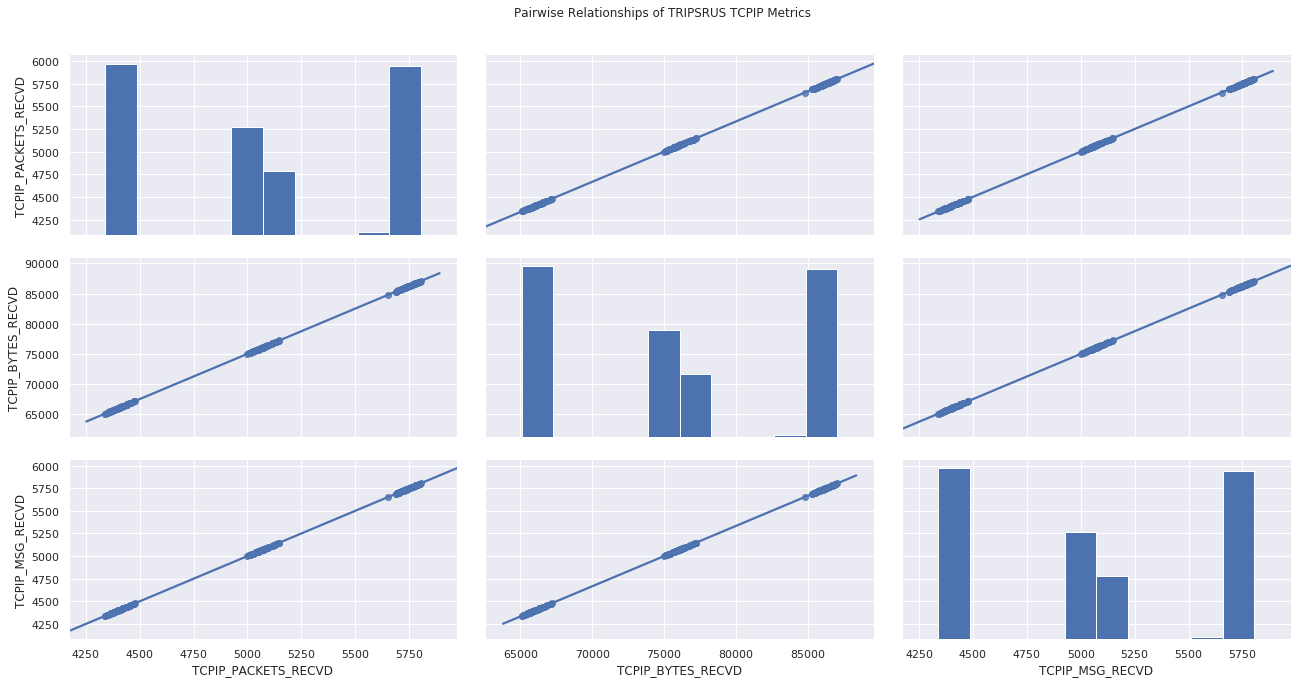

In [10]:
# Adjust DataFrame indexing for TRIPSRUS TCP/IP data
cdc_tcpip_tripsrus_df = cdc_tcpip_app_df.copy()
cdc_tcpip_tripsrus_df.columns = cdc_tcpip_app_df.columns.droplevel(1)
cdc_tcpip_tripsrus_df.describe()

# Construct pairwise relationship graphs for the TRIPSRUS TCP/IP data
fg = sns.pairplot(cdc_tcpip_tripsrus_df, kind='reg', height=3, aspect=2)
fg.fig.suptitle('Pairwise Relationships of TRIPSRUS TCPIP Metrics', y=1.05)
plt.show()

The identical distributions and exact linear regression lines for each of the scatterplots informs us that every inbound TRIPSRUS message contains the same number of TCP/IP packets and bytes. We can continue to investigate the inbound TRIPSRUS traffic by using only the *TCPIP_MSG_RECVD* column for its impact to the CPU utilization without sacrificing potential data points.

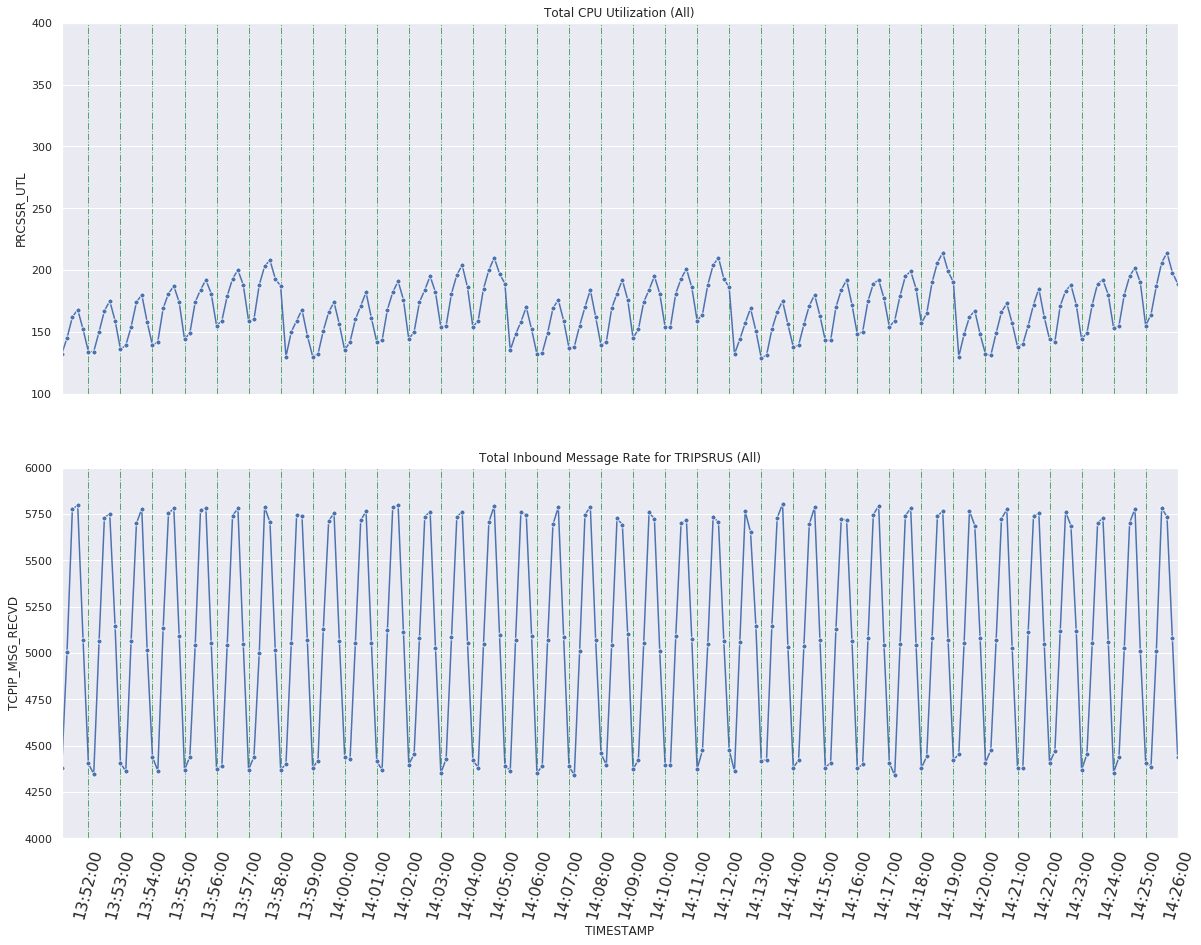

In [11]:
# Construct line graph of CPU utilization and inbound TRIPSRUS message rate
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=cdc_sysmsg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Total CPU Utilization (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(100, 400)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')

sns.lineplot(x=cdc_tcpip_tripsrus_df.index, y='TCPIP_MSG_RECVD', data=cdc_tcpip_tripsrus_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('Total Inbound Message Rate for TRIPSRUS (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(4000, 6000)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

The CPU utilization and inbound TRIPSRUS message rate have a similar oscillation in their values across the same period. But we cannot presume that the unexpected weekly CPU utilization growths are influenced by the rate of traffic being sent through the TRIPSRUS channel. To test this hypothesis, the previous method of calculating the daily rolling averages will be performed on both data sets to mitigate the influence of a daily trend pattern.

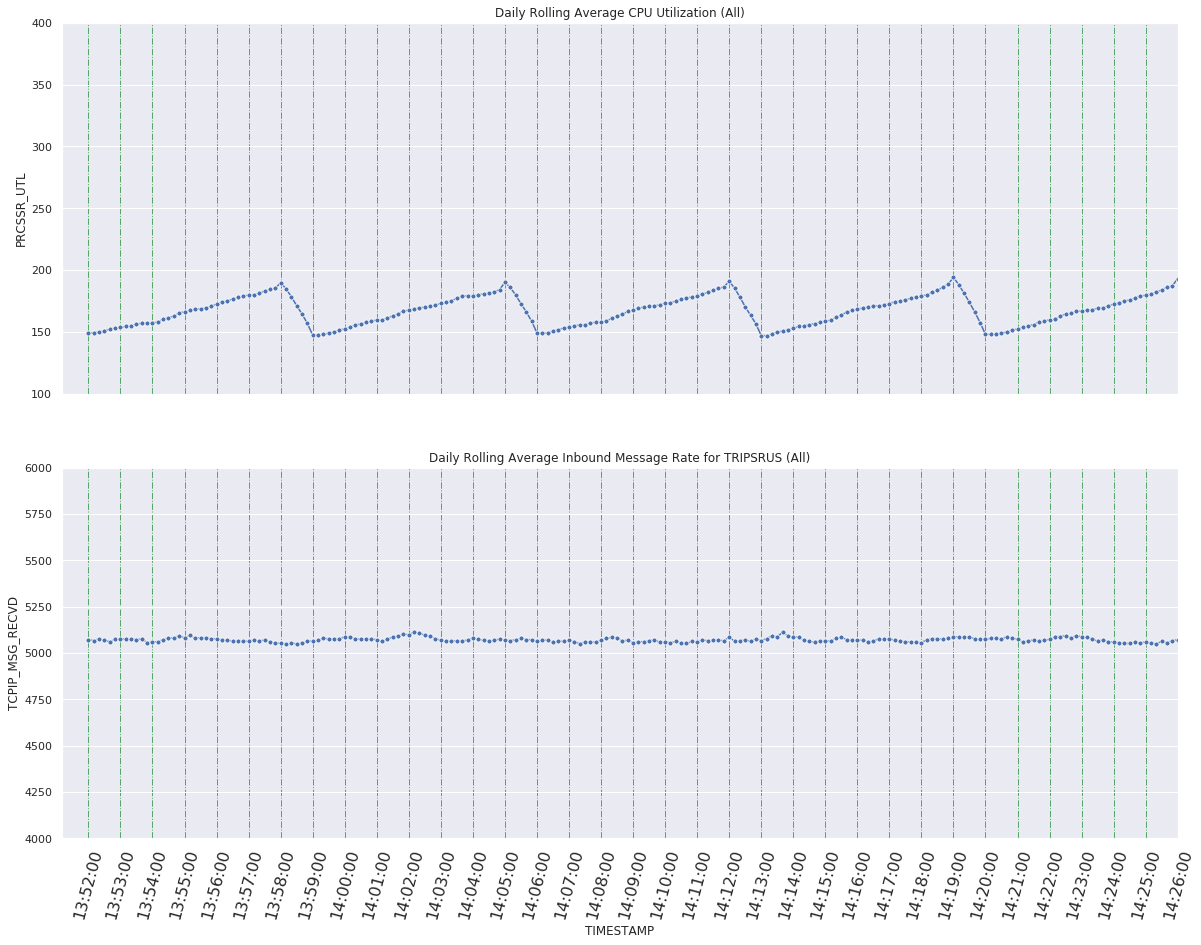

In [12]:
# Calculate daily rolling average of inbound TRIPSRUS message rate
cdc_tripsrus_dailyavg_df = cdc_tcpip_tripsrus_df.rolling(6).mean()

# Construct line graph of daily rolling average CPU utilization and inbound TRIPSRUS message rate
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Daily Rolling Average CPU Utilization (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(100, 400)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')

sns.lineplot(x=cdc_tripsrus_dailyavg_df.index, y='TCPIP_MSG_RECVD', data=cdc_tripsrus_dailyavg_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('Daily Rolling Average Inbound Message Rate for TRIPSRUS (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(4000, 6000)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

The previous line graphs show that the daily rolling average of the TRIPSRUS message rate are mostly constant at around 5100 messages per collection. There is virtually no correlation between the TRIPSRUS message rates and the weekly CPU utilization trend pattern. It is safe to presume now that any apparent correlation was between the TRIPSRUS message rates and the daily CPU utilization trend pattern. The *cdc_tcpip_df* DataFrame can be excluded from a further analysis because no active TCP/IP traffic shows a relationship with the unexpected CPU utilization growths.

If the incoming traffic into the z/TPF system is not unusual, the next reasonable step is to examine the amount of generated workload by the incoming traffic or system. The *CRTD_ENTS* column in the *cdc_sysmsg_df* DataFrame gives us the number of ECBs that were created during each collection, which is the only interesting metric that is available in this data set for this problem set.


In [ ]:
# Construct line graph of daily rolling average CPU utilization and number of created ECBs
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Daily Rolling Average CPU Utilization (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')

sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='CRTD_ENTS', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('Daily Rolling Average of Created ECBs (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

Because metrics with high variance can be difficult to visually identify a relationship, the Pearson correlation coefficient can be calculated to mathematically express the measurement of linear correlation between two metrics. An absolute correlation coefficient value of less than 0.1 would statistically indicate no linear relationship.

In [ ]:
# Construct correlation matrix heatmap between daily rolling average CPU utilization and relevant system message metrics
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix between CPU Utilization and System Message Metrics (Daily Rolling Average)')
sns.heatmap(cdc_sysmsg_dailyavg_df['CRTD_ENTS'].to_frame().corrwith(cdc_sysmsg_dailyavg_df['PRCSSR_UTL']).to_frame(),
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size': 30})
plt.show()

The *cdc_syslst_df* DataFrames contains system metrics about work that is waiting to be dispatched from each of the CPU loop lists. A quick analysis can help to verify that nothing unusual is occurring with the distribution of each CPU loop list.

In [ ]:
# Show CDC system list data columns
display(cdc_syslst_df.info())

# Display statistical summary of CDC system list data
display(cdc_syslst_df.describe())

In [ ]:
# Construct line graphs of daily rolling average of the relevant system list metrics
cdc_relevant_syslst_df = cdc_syslst_df[['CROSS_LIST', 'READY_LIST', 'ACTIVE_ECBS']]
cdc_relevant_syslst_dailyavg_df = cdc_relevant_syslst_df.rolling(6).mean()
cdc_relevant_syslst_dailyavg_df.plot.line(title='Daily Rolling Average z/TPF CPU Loop List Metrics',
                                           xlim=(first_collection_datetime, last_collection_datetime), 
                                           subplots=True, figsize=(15, 12))
plt.show()

In [ ]:
# Construct correlation matrix heatmap between daily rolling average CPU utilization and relevant system list metrics
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix between CPU Utilization and CPU Loop List Metrics (Daily Rolling Average)')
sns.heatmap(cdc_relevant_syslst_dailyavg_df.corrwith(cdc_sysmsg_dailyavg_df['PRCSSR_UTL']).to_frame(),
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size': 30})
plt.show()

The *CROSS_LIST*, *READY_LIST*, and *ACTIVE_ECBS* columns have a moderately-weak correlation with the weekly CPU utilization trend. A data scientist should have some understanding of the z/TPF environment to make an educated assessment on whether any correlation has the potential to reveal the cause of the problem set. In this case, the CPU loop lists would naturally accumulate waiting ECBs as the z/TPF system became too busy while processing existing work. Therefore, the CPU utilization growths would be the cause, not the effect, of the increasing size of those CPU loop lists.

While we were not able to locate the possible cause of the unexpected weekly CPU utilization trend by inspecting the CDC data sets, we did gain some valuable insights from our analysis. We were able to eliminate some system-wide behavior, as such system traffic and workload rates, as potential causes of the problem. We can further narrow our scope by investigating application-level metrics and other system-wide metrics that are not available from CDC

The name-value pair collection data set gives us more detailed system resource usage of ECBs based on meaingful attributes such as message type, customer channel, or application phase. The granularity of this data depends on the number of horizontal and vertical name-value pairs that areassigned during the life of an ECB. For this investigation, we filtered our name-value pair collection data set to contain only the CPU time and message count for each message type that is defined on our environment. 

In [ ]:
# Show NVPC data columns
nvpc_df.info()

In [ ]:
# Display statistical summary of each message type in the NVPC data
nvpc_msgtype_df = nvpc_df.pivot(columns='MSGTYPE')
nvpc_msgtype_df.describe()

By pivoting the name-value pair collection data set by the *MSGTYPE* column, we are able to identify three different message types (Booking, Shopping, and Utility).

The individual contribution of each message type to the total system CPU utilization can be calculated by the following expression, divided by the number of I-streams and the duration of a collection period:

$$T_{CPU}=\sum^{M_{TYPE}} (M_{CPU}*M_{COUNT})$$

In [ ]:
# Calculate the total CPU utilization per message type across eight I-streams & a ten-second collection (CPU_USED is in microseconds)
nvpc_df['TOTAL_CPU'] = np.round((nvpc_df['CPU_USED']*nvpc_df['MESSAGE_COUNT'])/(8*1000*10)).astype(np.int64)

An insightful assessment is determining how much of the total system CPU utilization is accounted for by our collected name-value pair collection data. While a higher message skip factor can significantly reduce the amount of data to be processed by RTMC, it also reduces the chances of capturing infrequent messages of significant importance that might explain a system-wide behavior. For the sample data, the message skip factor was set to zero so that only ECBs without an assigned name-value pairs are missing in the expected total CPU utilization.

In [ ]:
# Create a separate DataFrame for each message type
nvpc_booking_df = nvpc_df[nvpc_df['MSGTYPE'] == 'Booking']
nvpc_shopping_df = nvpc_df[nvpc_df['MSGTYPE'] == 'Shopping']
nvpc_utility_df = nvpc_df[nvpc_df['MSGTYPE'] == 'Utility']

display(nvpc_booking_df.CHANNEL.unique())
display(nvpc_shopping_df.CHANNEL.unique())
display(nvpc_utility_df.CHANNEL.unique())

In [ ]:
# Calculate TRIPSRUS message CPU utilization
nvpc_tripsrus_cpu_df = (nvpc_booking_df['TOTAL_CPU'] + nvpc_shopping_df['TOTAL_CPU']).to_frame()

# Construct line graph of CPU utilization for total system & TRIPSRUS messages
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=cdc_sysmsg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Total CPU Utilization (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(0, 250)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')


sns.lineplot(data=nvpc_tripsrus_cpu_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('TRIPSRUS CPU Utilization (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(0, 250)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=(cdc_sysmsg_df['PRCSSR_UTL'] - nvpc_tripsrus_cpu_df['TOTAL_CPU']), marker='o', markersize=8)
ax.set_title('Non-TRIPSRUS CPU Utilization (All)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.ylim(0, 250)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

Aside from the unaccounted-for server workload randomly consuming 6-8% CPU utilization, the TRIPSRUS traffic metrics captured by the name-value pair collection data seem to visually trend well with the total server CPU utilization.

In [ ]:
# Construct scatterplot of the total CPU utilization of each NVPC message type
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.scatterplot(x=nvpc_df.index, y='TOTAL_CPU', hue='MSGTYPE', style='MSGTYPE', s=100, data=nvpc_df)
ax.set_title('Total CPU Utilization per Message Type per Collection (All)')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', linestyle='-.')
plt.show()

From the scatterplot of the message types, you can gain several useful insights about their CPU utilization during each collection:
* Shopping messages consumes between 5-7.5% CPU utilization.
* Booking messages consumes about 1% CPU utilization at the start of the week, but grow to 7% CPU utilization by the end of the week.
* Utility messages occur only at the end of each week, consuming about 3% CPU utilization.

Daily rolling average of the total system and Booking message CPU utilization are calculated and analyzed to confirm if their weekly trend patterns are related.

In [ ]:
# Calculate daily rolling average of Booking CPU utilization
nvpc_booking_dailyavg_df = nvpc_booking_df['TOTAL_CPU'].rolling(6).mean()

# Construct line graph of daily rolling average CPU utilization of total system and Booking messages
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=cdc_sysmsg_dailyavg_df.index, y='PRCSSR_UTL', data=cdc_sysmsg_dailyavg_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Daily Rolling Average CPU Utilization (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')

sns.lineplot(data=nvpc_booking_dailyavg_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('Daily Rolling Average NVPC Booking CPU Utilization (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

In [ ]:
# Construct correlation matrix heatmap between daily rolling average CPU utilization of total system and Booking messages
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix between Total System CPU Utilization and Booking CPU Utilization (Daily Rolling Average)')
sns.heatmap(nvpc_booking_dailyavg_df.to_frame().corrwith(cdc_sysmsg_dailyavg_df['PRCSSR_UTL']).to_frame(),
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size': 30})
plt.show()

The near-perfect possible correlation coefficient value indicates that the Booking messages are the cause of the unexpected weekly CPU utilization trend. The remaining Booking data set can be examined further to get additional relevant information.

In [ ]:
# Construct line graph of the average CPU cost and message count of Booking messages
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,15))
sns.lineplot(x=nvpc_booking_df.index, y='CPU_USED', data=nvpc_booking_df, marker='o', markersize=5, ax=ax[0])
ax[0].set_title('Booking Message Average CPU Cost (All)')
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[0])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')

sns.lineplot(x=nvpc_booking_df.index, y='MESSAGE_COUNT', data=nvpc_booking_df, marker='o', markersize=5, ax=ax[1])
ax[1].set_title('Booking Message Count (All)')
ax[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.sca(ax[1])
plt.xlim(first_collection_datetime, last_collection_datetime)
plt.xticks(rotation=75, fontsize=16, ha='center')
plt.grid(axis='x', which='major', color='g', linestyle='-.')
plt.show() 

The previous graphs show the rising average CPU cost of TRIPSRUS Booking messages, not the inbound traffic rate, as the likely culprit for the overall CPU utilization problem. The cost of a TRIPSRUS Booking message is slowly increasing an additional microsecond of CPU time per day until the end of the 7th day. At the end of the week, the average CPU cost drops back to two microseconds per message.

The additional data points illustrate the invaluable findings that can be obtained from only name-value pair collection data and helps to devise an appropriate action plan for the problem. Though there is not enough data to statistically prove that the Utility messages are associated with the changing Booking message cost, it is likely valuable information to the enterprise environment experts as part of their own investigation into the application code base.

## GitHub repository
---

https://github.com/IBM/tpf-ds-notebooks

## License
---

Copyright 2019 IBM Corporation  

Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  

    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,  
software distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and limitations under the License.